# qbic-pipelines/root-tissue-analysis
# Pipeline Report

**Description:** pH determination analysis

----------------------------------------------------------

In [1]:
import itertools
import os
import sys

import click
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import numpy as np
from rich import print, traceback
from statannotations.Annotator import Annotator
from IPython.display import display, Markdown
%matplotlib inline
import tifffile as tiff
import matplotlib.patches as mpatches

## to keep the report clean
import warnings
warnings.filterwarnings('ignore')

In [7]:
ratio_path = "ratios.tsv"
img_path = "brightfields/"
pred_path = "predictions/"
ratio_img_path = "ratios/"
ome_output_path = "ome_output/"
ome_output_uncert_path = "ome_output_uncert/"
ome_output_ggcam_path = "ome_output_ggcam/"

## Statistics per Tissue Zone
------------------------------------

### Meristematic Zone

,Test Description,Test Name,Statistic Symbol,Value,p-value,Corrected Significance,Corrected Method,alpha,Sample Comparison
0,Welch's t-test independent samples,t-test_welch,t,NaN,NaN,None,None,0.05,bri1-301 Mock vs. bri1-301 BL


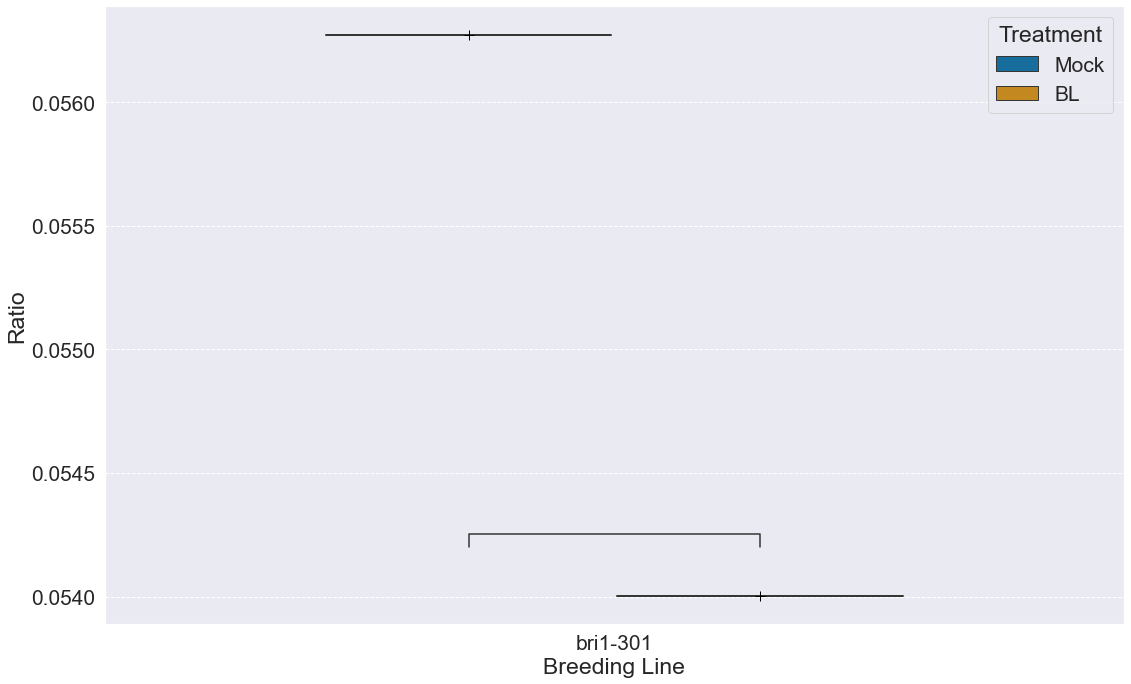

### Early Elongation Zone

,Test Description,Test Name,Statistic Symbol,Value,p-value,Corrected Significance,Corrected Method,alpha,Sample Comparison
0,Welch's t-test independent samples,t-test_welch,t,NaN,NaN,None,None,0.05,bri1-301 Mock vs. bri1-301 BL


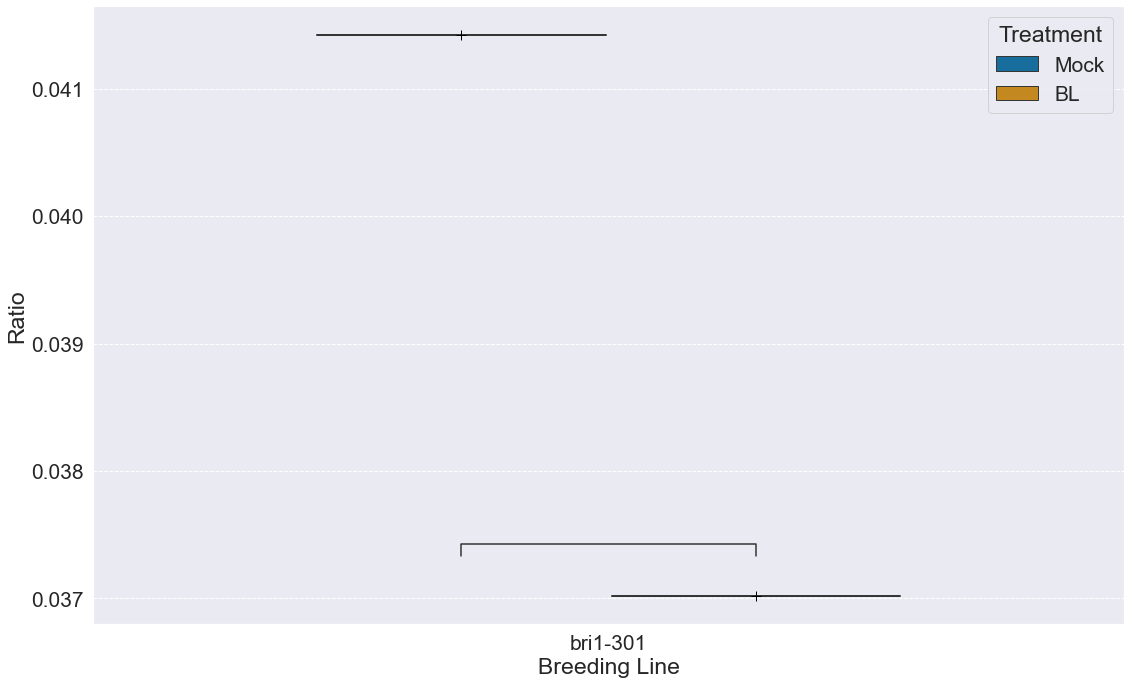

In [3]:
df = pd.read_csv(ratio_path, sep = '\t', header=0)
sns.set(style="darkgrid", font_scale=1.5, palette="colorblind",
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
plt.rcParams["figure.figsize"] = (10 * 1.62, 10)  # (w, h)
output = "output"
font_options = {
    "axes.labelsize": 23,
    "font.size": 23,
    "legend.fontsize": 21,
    'legend.title_fontsize': 23,
    "xtick.labelsize": 21,
    "ytick.labelsize": 21,
}
plt.rcParams.update(font_options)
df = df.dropna()
product = set(itertools.product(df['Breeding Line'], df['Treatment']))
box_pairs = ([(a, b) for a, b in itertools.combinations(product, 2) if a[0] == b[0]])
os.makedirs(output, exist_ok=True)
for zone in df["Zone"].unique():
    ## test
    data = df[df["Zone"] == zone]
    ax = sns.boxplot(x="Breeding Line", y="Ratio", hue="Treatment",
                     data=data, showmeans=True, meanprops={"marker": "+",
                                                                             "markeredgecolor": "black",
                                                                             "markersize": "10"})
    annotator = Annotator(ax, box_pairs, data=data, x="Breeding Line", y="Ratio", hue="Treatment",verbose=False)
    display(Markdown(f"### {zone}"))
    annotator.configure(test='t-test_welch', show_test_name=False, text_format='star', loc='inside')
    annotator.apply_test()
    ax, test_results = annotator.annotate()
    dfs = pd.DataFrame()
    for res in test_results:
        dic = res.data.__dict__
        dfss = pd.DataFrame.from_dict(dic)
        dfss['comb'] = f"{dic['group1'][0]} {dic['group1'][1]} vs. {dic['group2'][0]} {dic['group2'][1]}"
        dfs = dfs.append(dfss.drop(0, axis=0), ignore_index=True)
    
    output_table = dfs.drop(['group1', 'group2'], axis=1)
    output_table.rename(columns={'test_description': 'Test Description',
                        'test_short_name': 'Test Name',
                        'stat_str': 'Statistic Symbol',
                        'stat_value': 'Value',
                        'pvalue': 'p-value',
                        '_corrected_significance': 'Corrected Significance',
                        '_correction_method': 'Corrected Method',
                        'alpha': 'alpha',
                        'comb': 'Sample Comparison'}, inplace=True)
    display(output_table)
    
    annotator.reset_configuration()
    plt.tight_layout()
    plt.show()
    plt.close()

## Ratio Values
-------------------

In [4]:
df.rename(columns={'Ratio': 'Average Ratio Value',
                   'Zone': 'Tissue Zone'}, inplace=True)
display(df)

,Filename,Treatment,Breeding Line,Average Ratio Value,Tissue Zone
0,Image 70,Mock,bri1-301,0.056274,Meristematic Zone
1,Image 71,Mock,bri1-301,0.041423,Early Elongation Zone
2,Image 114,BL,bri1-301,0.054001,Meristematic Zone
3,Image 115,BL,bri1-301,0.037018,Early Elongation Zone


## Image Ouput Visualization: Segmentation Prediction
------------------------------------

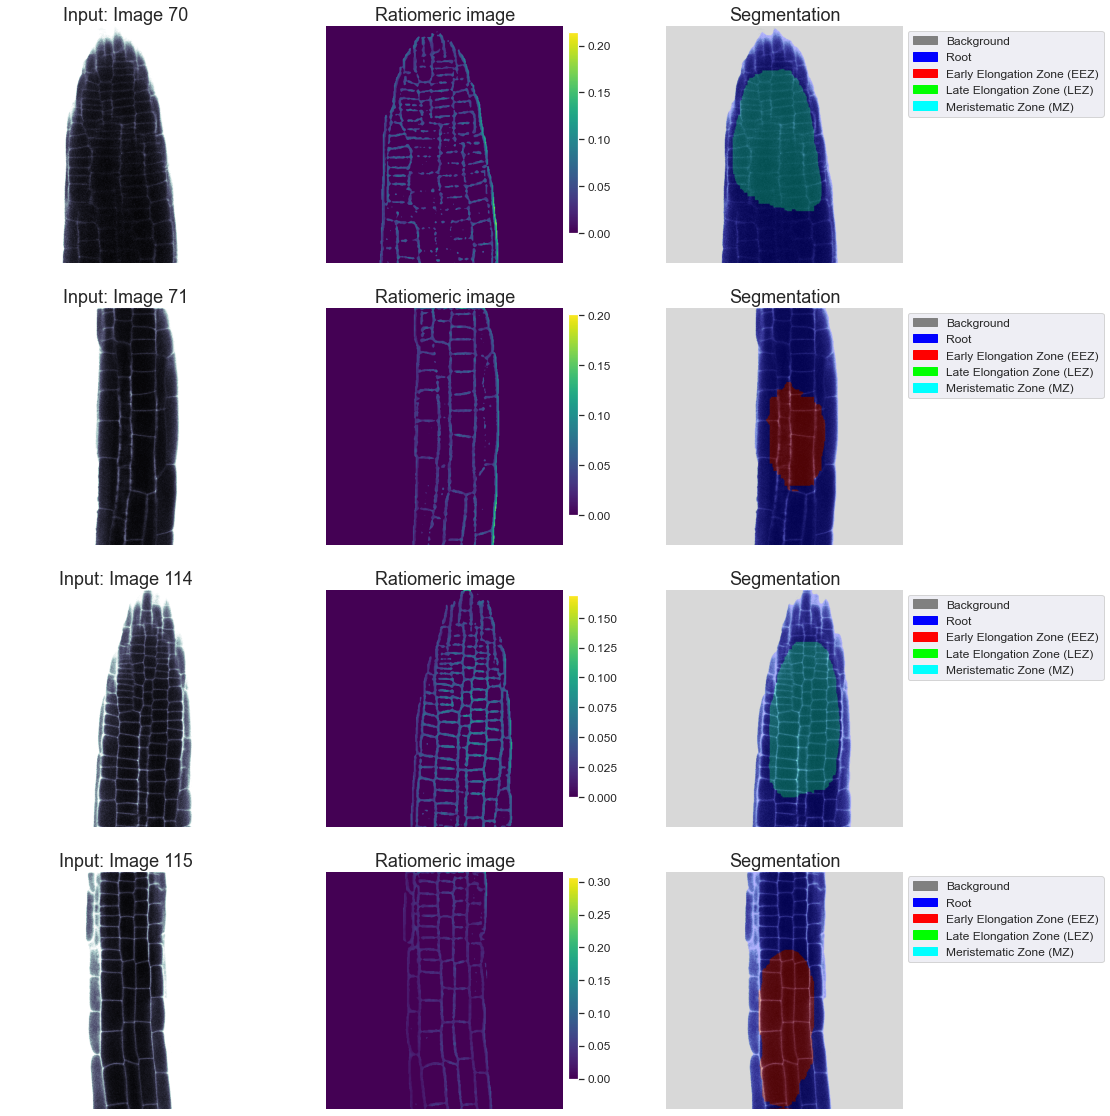

In [36]:
t = 1.0 #alpha
cmap = {0:[0.5, 0.5, 0.5, t],
        1:[0.0, 0.0, 1.0, t],
        2:[1.0, 0.0, 0.0, t],
        3:[0.0, 1.0, 0.0, t],
        4:[0.0, 1.0, 1.0, t]}
labels = {0:'Background',
          1:'Root',
          2:'Early Elongation Zone (EEZ)',
          3:'Late Elongation Zone (LEZ)',
          4:'Meristematic Zone (MZ)'}
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

fig, axs = plt.subplots(len(df["Filename"]), 3, figsize=(17, len(df["Filename"])*4))
for idx, file in enumerate(df["Filename"]):
    
    #img = plt.imread(f"{img_path}{file}.tif")
    #ratio_img = plt.imread(f"{ratio_img_path}{file}_ratio.tif")
    #pred_img = np.load(f"{pred_path}{file}.npy")
    
    img = tiff.imread(f"{ome_output_path}{file}.ome.tif")
    
    axs[idx][0].set_axis_off()
    axs[idx][0].imshow(img[0], cmap='bone')
    axs[idx][0].set_title("Input: " + file)
    
    axs[idx][1].set_axis_off()
    ratio_img = axs[idx][1].imshow(img[1], cmap='viridis')
    axs[idx][1].set_title("Ratiomeric image")
    cb = fig.colorbar(ratio_img, ax=axs[idx][1], shrink=0.85, anchor=(-0.3, 0.85))
    cb.ax.tick_params(labelsize=12)
    
    axs[idx][2].set_axis_off()
    label_img = np.array([[cmap[i] for i in j] for j in img[2]])
    axs[idx][2].imshow(img[0], cmap='bone')
    axs[idx][2].imshow(label_img, alpha=0.3)
    axs[idx][2].set_title("Segmentation")
    axs[idx][2].legend(handles=patches, loc='center left', borderaxespad=0., fontsize=12, bbox_to_anchor=(1.02, 0.8))
    
fig.tight_layout()

## Image Ouput Visualization: Uncertainty of Prediction
------------------------------------

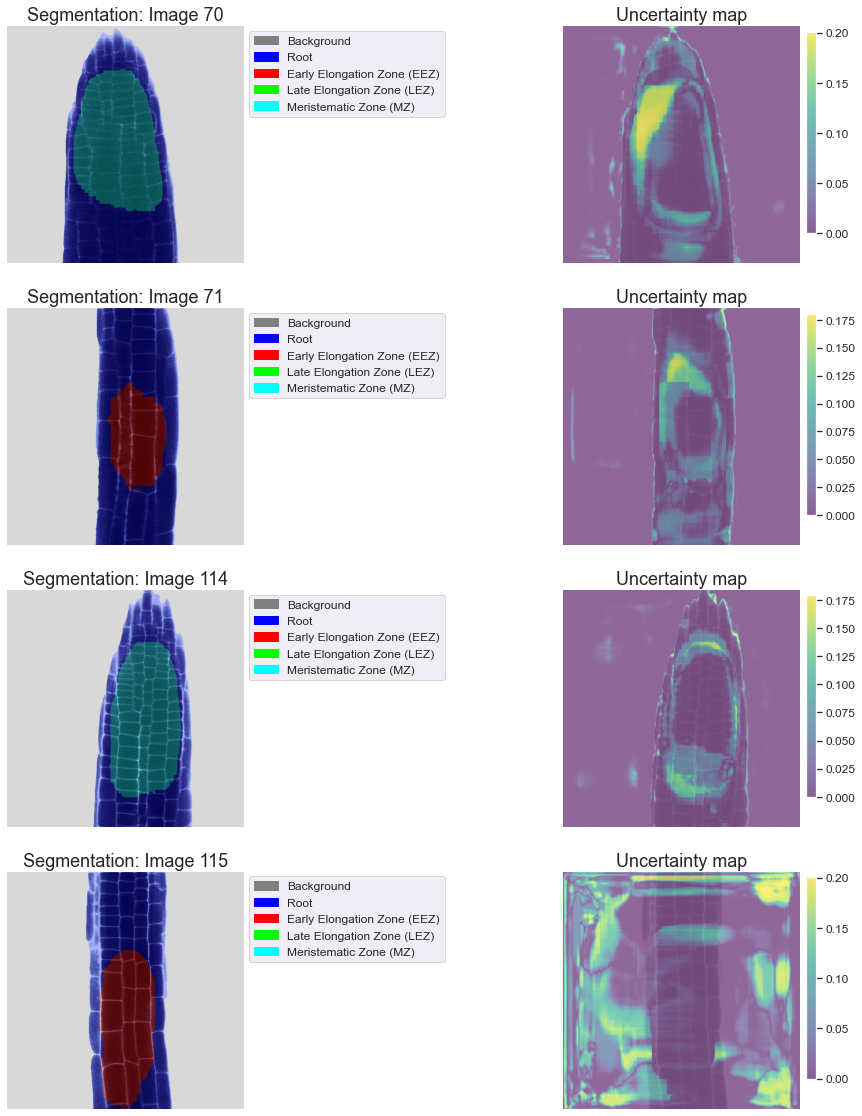

In [97]:
fig, axs = plt.subplots(len(df["Filename"]), 2, figsize=(15, len(df["Filename"])*4))
for idx, file in enumerate(df["Filename"]):
    
    pred_img = tiff.imread(f"{ome_output_path}{file}.ome.tif")
    img = tiff.imread(f"{ome_output_uncert_path}{file}_uncert.ome.tif")
    
    axs[idx][0].set_axis_off()
    label_img = np.array([[cmap[i] for i in j] for j in pred_img[2]])
    axs[idx][0].imshow(pred_img[0], cmap='bone')
    axs[idx][0].imshow(label_img, alpha=0.3)
    axs[idx][0].set_title("Segmentation: " + file)
    axs[idx][0].legend(handles=patches, loc='center left', borderaxespad=0., fontsize=12, bbox_to_anchor=(1.02, 0.8))
    
    axs[idx][1].set_axis_off()
    axs[idx][1].imshow(img[0], cmap='gray', alpha=0.3)
    uncert_map = axs[idx][1].imshow(img[1], cmap='viridis', alpha=0.6)
    axs[idx][1].set_title("Uncertainty map")
    cb = fig.colorbar(uncert_map, ax=axs[idx][1], shrink=0.85, anchor=(-0.3, 0.85))
    cb.ax.tick_params(labelsize=12)
    
    
fig.tight_layout()

## Image Ouput Visualization: Input Feature Importance (Guided Grad-CAM)
------------------------------------

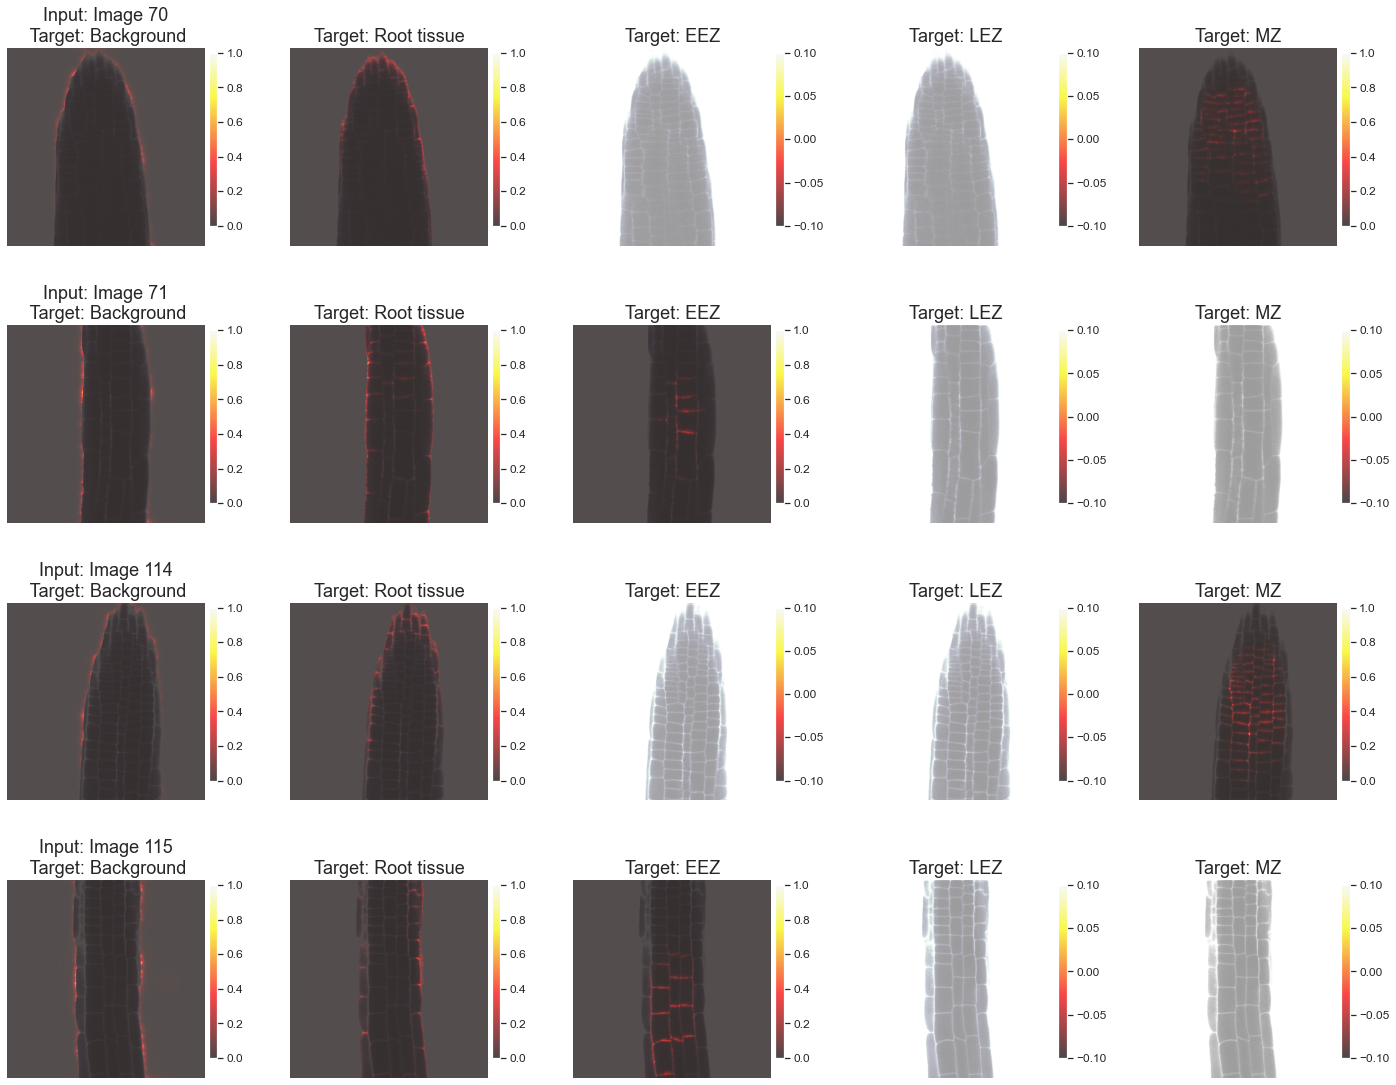

In [85]:
def normMap(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) 

fig, axs = plt.subplots(len(df["Filename"]), 5, figsize=(20, len(df["Filename"])*4))
for idx, file in enumerate(df["Filename"]):
    
    img = tiff.imread(f"{ome_output_ggcam_path}{file}_ggcam.ome.tif")
    
    img[1] = normMap(img[1])
    axs[idx][0].set_axis_off()
    axs[idx][0].imshow(img[0], cmap='bone', alpha=0.4)
    feat_imp = axs[idx][0].imshow(img[1], cmap='hot', alpha=0.7)
    axs[idx][0].set_title("Input: " + file + "\n Target: Background")
    cb = fig.colorbar(feat_imp, ax=axs[idx][0], shrink=0.7, anchor=(-0.3, 0.6))
    cb.ax.tick_params(labelsize=12)
    
    img[2] = normMap(img[2])
    axs[idx][1].set_axis_off()
    axs[idx][1].imshow(img[0], cmap='bone', alpha=0.4)
    feat_imp = axs[idx][1].imshow(img[2], cmap='hot', alpha=0.7)
    axs[idx][1].set_title("Target: Root tissue")
    cb = fig.colorbar(feat_imp, ax=axs[idx][1], shrink=0.7, anchor=(-0.3, 0.6))
    cb.ax.tick_params(labelsize=12)
    
    img[3] = normMap(img[3])
    axs[idx][2].set_axis_off()
    axs[idx][2].imshow(img[0], cmap='bone', alpha=0.4)
    feat_imp = axs[idx][2].imshow(img[3], cmap='hot', alpha=0.7)
    axs[idx][2].set_title("Target: EEZ")
    cb = fig.colorbar(feat_imp, ax=axs[idx][2], shrink=0.7, anchor=(-0.3, 0.6))
    cb.ax.tick_params(labelsize=12)
    
    img[4] = normMap(img[4])
    axs[idx][3].set_axis_off()
    axs[idx][3].imshow(img[0], cmap='bone', alpha=0.4)
    feat_imp = axs[idx][3].imshow(img[4], cmap='hot', alpha=0.7)
    axs[idx][3].set_title("Target: LEZ")
    cb = fig.colorbar(feat_imp, ax=axs[idx][3], shrink=0.7, anchor=(-0.3, 0.6))
    cb.ax.tick_params(labelsize=12)
    
    img[5] = normMap(img[5])
    axs[idx][4].set_axis_off()
    axs[idx][4].imshow(img[0], cmap='gray', alpha=0.4)
    feat_imp = axs[idx][4].imshow(img[5], cmap='hot', alpha=0.7)
    axs[idx][4].set_title("Target: MZ")
    cb = fig.colorbar(feat_imp, ax=axs[idx][4], shrink=0.7, anchor=(-0.3, 0.6))
    cb.ax.tick_params(labelsize=12)
    
fig.tight_layout()